# PyTorch 网络进行分类任务

## 使用多层感知器进行分类

### 数据样本如下

In [1]:
import torch
import numpy as np
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_decision_boundary(model, x, y):
    # Set min and max values and give it some padding
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(x[:, 0], x[:, 1], c=y.reshape(-1), s=40, cmap=plt.cm.Spectral)

In [3]:
np.random.seed(1)
m = 400 # 样本数量
N = int(m/2) # 每一类的点的个数
D = 2 # 维度
x = np.zeros((m, D))
y = np.zeros((m, 1), dtype='uint8') # label 向量，0 表示红色，1 表示蓝色
a = 4

for j in range(2):
    ix = range(N*j,N*(j+1))
    t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
    r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
    x[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

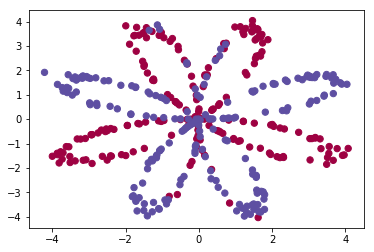

In [4]:
plt.scatter(x[:, 0], x[:, 1], c=y.reshape(-1), s=40, cmap=plt.cm.Spectral)

### 先尝试用逻辑回归来处理

In [5]:
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()

w = nn.Parameter(torch.randn(2, 1))
b = nn.Parameter(torch.zeros(1))

optimizer = torch.optim.SGD([w, b], 1e-1)

def logistic_regression(x):
    #return F.sigmoid(torch.mm(x, w) + b)
    return torch.mm(x, w) + b

criterion = nn.BCEWithLogitsLoss()

In [6]:
for e in range(100):
    out = logistic_regression(Variable(x))
    loss = criterion(out, Variable(y))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 20 == 0:
        print('epoch: {}, loss: {}'.format(e+1, loss.data[0]))

epoch: 20, loss: 0.691776871681
epoch: 40, loss: 0.673560976982
epoch: 60, loss: 0.67317122221
epoch: 80, loss: 0.673152685165
epoch: 100, loss: 0.673148572445


In [7]:
def plot_logistic(x):
    x = Variable(torch.from_numpy(x).float())
    out = F.sigmoid(logistic_regression(x))
    #out = logistic_regression(x)
    out = (out > 0.5) * 1
    return out.data.numpy()

Text(0.5,1,u'logistic regression')

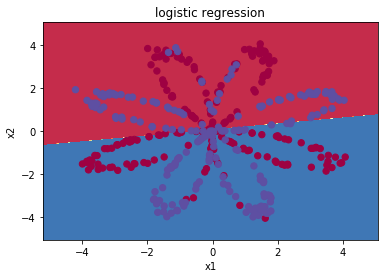

In [8]:
plot_decision_boundary(lambda x: plot_logistic(x), x.numpy(), y.numpy())
plt.title('logistic regression')

### 使用多层感知器

### Module方式构建网络

In [9]:
# Module实现多层感知器
class module_net(nn.Module):
    def __init__(self, num_input, num_hidden, num_output):
        super(module_net, self).__init__()
        self.layer0 = nn.Linear(num_input, num_hidden)
        self.layer1 = nn.Tanh()
        self.layer2 = nn.Linear(num_hidden, num_hidden)
        self.layer3 = nn.Tanh()
        self.layer4 = nn.Linear(num_hidden, num_hidden)
        self.layer5 = nn.Tanh()
        self.layer6 = nn.Linear(num_hidden, num_output)
        
    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        return x

In [10]:
# 将数据集转换成tensor类型
#x = torch.from_numpy(x).float()
#y = torch.from_numpy(y).float()

# 实例化一个网络
net = module_net(2, 5, 1)

### 训练网络

In [11]:
# 定义优化器
optim = torch.optim.SGD(net.parameters(), 1.)

criterion = nn.BCEWithLogitsLoss()

In [12]:
# 我们训练 2000 次
for e in range(2000):
    out = net(Variable(x))
    loss = criterion(out, Variable(y))
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (e + 1) % 1000 == 0:
        print('epoch: {}, loss: {}'.format(e+1, loss.data[0]))

epoch: 1000, loss: 0.19792021811
epoch: 2000, loss: 0.161887004972


In [13]:
def plot_net(x):
    out = F.sigmoid(net(Variable(torch.from_numpy(x).float()))).data.numpy()
    out = (out > 0.5) * 1
    return out

Text(0.5,1,u'sequential')

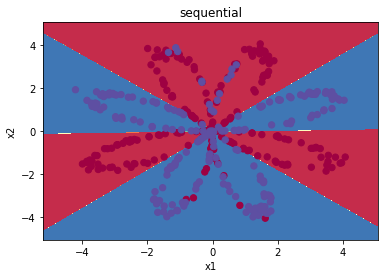

In [14]:
plot_decision_boundary(lambda x: plot_net(x), x.numpy(), y.numpy())
plt.title('sequential')